<a href="https://colab.research.google.com/github/victorgsosa/GANMarketing/blob/main/COCO_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

In [4]:
data_dir=None
if IS_COLAB:
    data_dir = "data"
else:
# configuración local para evitar errores de memoria
    gpu_devices = tf.config.experimental.list_physical_devices('GPU')
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)

In [5]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True,data_dir=data_dir)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling coco-train.tfrecord...:   0%|          | 0/118287 [00:00<?, ? examples/s]

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling coco-validation.tfrecord...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling coco-test.tfrecord...:   0%|          | 0/40670 [00:00<?, ? examples/s]

Dataset coco downloaded and prepared to C:\Users\Juan Marriaga\tensorflow_datasets\coco\2017\1.1.0. Subsequent calls will reuse this data.


In [43]:
# Number of classes of COCO
classes = dataset_info.features['objects']['label'].names
num_classes = dataset_info.features['objects']['label'].num_classes

In [44]:
dataset_info.features['objects']['label'].shape

()

In [11]:
dataset_info

tfds.core.DatasetInfo(
    name='coco',
    full_name='coco/2017/1.1.0',
    description="""
    COCO is a large-scale object detection, segmentation, and
    captioning dataset.
    
    Note:
     * Some images from the train and validation sets don't have annotations.
     * Coco 2014 and 2017 uses the same images, but different train/val/test splits
     * The test split don't have any annotations (only images).
     * Coco defines 91 classes but the data only uses 80 classes.
     * Panotptic annotations defines defines 200 classes but only uses 133.
    """,
    config_description="""
    
    This version contains images, bounding boxes and labels for the 2017 version.
    
    """,
    homepage='http://cocodataset.org/#home',
    data_path='C:\\Users\\Juan Marriaga\\tensorflow_datasets\\coco\\2017\\1.1.0',
    download_size=25.20 GiB,
    dataset_size=24.98 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': 

In [27]:
train_dataset

<PrefetchDataset shapes: {image: (None, None, 3), image/filename: (), image/id: (), objects: {area: (None,), bbox: (None, 4), id: (None,), is_crowd: (None,), label: (None,)}}, types: {image: tf.uint8, image/filename: tf.string, image/id: tf.int64, objects: {area: tf.int64, bbox: tf.float32, id: tf.int64, is_crowd: tf.bool, label: tf.int64}}>

['image', 'image/filename', 'image/id', 'objects']
['image', 'image/filename', 'image/id', 'objects']
['image', 'image/filename', 'image/id', 'objects']
['image', 'image/filename', 'image/id', 'objects']
['image', 'image/filename', 'image/id', 'objects']


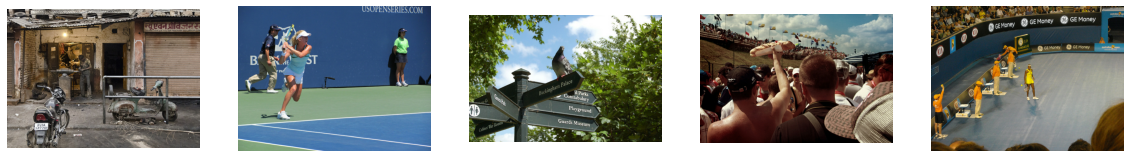

In [45]:
samples=5
ds = train_dataset.take(samples)  # Only take a single example
plt.figure(figsize=(4*samples,3))
index=0
for example in ds:
    plt.subplot(1, samples, index + 1)
    index+=1
    print(list(example.keys()))
    image = example["image"]
    plt.imshow(image)
    plt.axis("off")

In [ ]:
def preprocess_data(sample):
    """Applies preprocessing step to a single sample

    Arguments:
      sample: A dict representing a single training sample.

    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    return image, class_id

In [ ]:
autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset[0]